In [1]:
import pandas as pd
import ruptures as rpt
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
%matplotlib inline
plt.tight_layout()
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 5)

<Figure size 640x480 with 0 Axes>

In [218]:
def strucchanges(series, penalty=15, model="rbf", n_bkps=3):
    algo = rpt.Binseg(model=model, jump=100).fit(series.values)
    result = algo.predict(n_bkps=n_bkps, pen=penalty)
    return series.iloc[np.array(result) - 1].index.tolist()

def plot_strucchanges(data, currency, ts_name, penalty=15, model="rbf", n_bkps=3):
    series = data[currency].dropna()
    plt.plot(series, linewidth=1)

    changes = [series.index[0]]+strucchanges(series, penalty=penalty, model=model, n_bkps=n_bkps)

    # Color the entire background first
    for i in range(len(changes) - 1):
        start_change = changes[i]
        end_change = changes[i + 1]
        if i % 2 == 0:
            plt.axvspan(start_change, end_change, facecolor='blue', alpha=0.2, edgecolor='none')
        else:
            plt.axvspan(start_change, end_change, facecolor='red', alpha=0.2, edgecolor='none')

    plt.xticks(changes, [change.strftime('%d-%m-%Y') for change in changes], rotation=-45, fontsize=8)
    plt.title(f"{currency.split('.')[-1]}{ts_name}")
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.show()

In [3]:
# Load Data
belarus = pd.read_csv("data/FX_IDC_USDBYN, 1D.csv")[['time', 'close']]
ukraine = pd.read_csv("data/FX_IDC_USDUAH, 1D.csv")[['time', 'close']]
russia = pd.read_csv("data/FX_IDC_USDRUB, 1D.csv")[['time', 'close']]
euro = pd.read_csv("data/FX_IDC_USDEUR, 1D.csv")[['time', 'close']]
china = pd.read_csv("data/FX_IDC_USDCNY, 1D.csv")[['time', 'close']]
poland = pd.read_csv("data/FX_IDC_USDPLN, 1D.csv")[['time', 'close']]
turkey = pd.read_csv("data/FX_IDC_USDTRY, 1D.csv")[['time', 'close']]
pound = pd.read_csv("data/FX_IDC_USDGBP, 1D.csv")[['time', 'close']]


In [4]:
# Read Dates
for dataset in [belarus, russia, ukraine, euro, china, poland, turkey, pound]:
    dataset['time'] = pd.to_datetime(dataset['time'], format="%Y-%m-%dT%H:%M:%S%z")

In [253]:
# BUILDING DATAFRAMES

# Merging datasets
time_series = euro.set_index('time').add_suffix('.EUR').join([
    pound.set_index('time').add_suffix('.GBP'),
    russia.set_index('time').add_suffix('.RUB'),
    ukraine.set_index('time').add_suffix('.UAH'),
    belarus.set_index('time').add_suffix('.BYR'),
    china.set_index('time').add_suffix('.CNY'),
    poland.set_index('time').add_suffix('.PLN'),
    turkey.set_index('time').add_suffix('.TRY')
], how='left')

# Calculate returns
returns = time_series.pct_change() * 100

# Rolling Standard Deviations
rolling_std = pd.DataFrame()
for i in time_series.columns:
    rolling_std[i] = time_series[i].dropna().rolling(400).std()

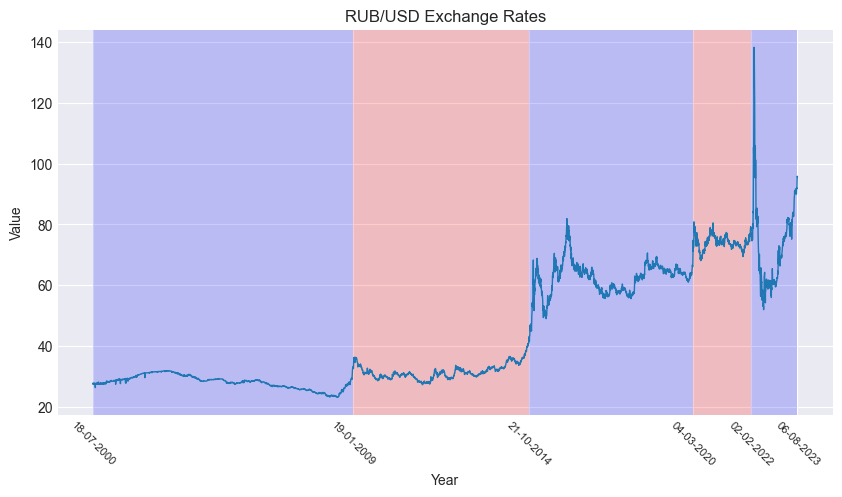

In [292]:
currency = 'close.PLN'
plot_strucchanges(time_series, currency, '/USD Exchange Rates', model='rbf', n_bkps=4, penalty=30)
plot_strucchanges(returns, currency, '/USD Returns', model='rbf', n_bkps=4, penalty=30)
plot_strucchanges(rolling_std, currency, '/USD Rolling Standard Deviations', model='rbf', n_bkps=4, penalty=30)